## Aim: 
Perform weight and unit pruning on the MNIST model, and observe change in accuracy.
## Hypothesis: 
As the k% of pruning will increase, the accuracy should also decrease, the affect will be more drastic on  dense layers of smaller units than for larger dense layers.

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
"""
Packages required:
numpy
pandas
matpoltlib
tensorflow
keras
"""

import numpy as np 
from numpy import linalg as LA
import matplotlib.pyplot as plt
import os
import time
import pandas as pd

from keras.utils import to_categorical
from keras.datasets import mnist
from keras.models import Sequential
from keras.models import clone_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
#equivalent to setting data_format = 'channels_first' for Conv2D
from keras import backend as K
K.set_image_dim_ordering('th')

%matplotlib inline

Using TensorFlow backend.


In [6]:
np.random.seed(123)

In [7]:
class DigitClassification:
    """Model formation- training and evaluation."""
    
    def __init__(self):
        """Set the initial model parameters."""
        (self.X_train, self.y_train), (self.X_test, self.y_test) = DigitClassification.load_data()
        _, self.image_row, self.image_col = self.X_train.shape
        self.num_channels = 1
        self.num_classes = 10
        #Initialise the Keras model
        self.model= Sequential()
            
    @classmethod
    def load_data(cls):
        """Load the MNIST dataset, and return the test-train tuple."""
        return mnist.load_data()
    
    def preprocessing(self):
        """Preprocessing to fit the NN input format."""
        # Re-shape
        self.X_train = self.X_train.reshape(self.X_train.shape[0], self.num_channels, self.image_row, self.image_col).astype('float32')
        self.X_test = self.X_test.reshape(self.X_test.shape[0], self.num_channels, self.image_row, self.image_col).astype('float32')
        # Re-scale
        self.X_train = self.X_train / 225
        self.X_test = self.X_test / 225
        print("X_train modified shape=", self.X_train.shape)
        print("X_test modified shape=", self.X_test.shape)
        # One-hot-key for digits 0-9
        self.y_train = to_categorical(self.y_train, self.num_classes)
        self.y_test = to_categorical(self.y_test, self.num_classes)
     
    def create_model(self):
        """Build the Model's Skeleton."""
        dense_classes = [1000, 500, 200]
        # Add a Cov layer
        self.model.add(Conv2D(filters=5, kernel_size=(5,5), activation='relu', input_shape=(self.num_channels, self.image_row, self.image_col)))
        self.model.add(MaxPooling2D(pool_size=(2,2)))
        self.model.add(Flatten())
        # Dense layers 1000,1000,500,200
        self.model.add(Dense(dense_classes[0], activation='relu'))
        self.model.add(Dense(dense_classes[0], activation='relu'))
        self.model.add(Dense(dense_classes[1], activation='relu'))
        self.model.add(Dense(dense_classes[2], activation='relu'))
        # Output layer
        self.model.add(Dense(self.num_classes, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    def train_model(self, batch_size, epochs):
        """Perform training on the model created before."""
        _start_training = time.time()
        self.model.fit(self.X_train, self.y_train, batch_size=batch_size, epochs=epochs, validation_data=(self.X_test, self.y_test))
        print("Time taken for training =", time.time() - _start_training)

    def evaluate_model(self):
        """Evalute the model on test data."""
        score = self.model.evaluate(self.X_test, self.y_test)
        return score[1]
    
    def run_(self, batch_size=500, epochs=10):
        """End-2-End training to create a model."""
        self.preprocessing()
        self.create_model()
        self.train_model(batch_size, epochs)
        print("Test Accuracy=", self.evaluate_model())

In [8]:
class Utility:
    """Consists of uility functions used by the model."""
    
    @staticmethod
    def percent_2_num(k_per, total):
        return int(k_per * total / 100)
    
    @staticmethod
    def get_indices_of_k_smallest(arr, k):
        # https://stackoverflow.com/questions/34226400/find-the-index-of-the-k-smallest-values-of-a-numpy-array/51523226
        idx = np.argpartition(arr.ravel(), k)
        return np.array(np.unravel_index(idx, arr.shape))[:, range(k)].transpose().tolist()
    
    @staticmethod
    def create_initial_dataframe(row_index, col_index, default_value):
        return pd.DataFrame(index=row_index, columns=col_index).fillna(default_value)

In [9]:
digit_classifier = DigitClassification() #Create an digit_classification object
digit_classifier.run_()
print("Baseline Model generated.")

11493376/11490434 [==============================] - 100s 9us/step
X_train modified shape= (60000, 1, 28, 28)
X_test modified shape= (10000, 1, 28, 28)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 225us/step - loss: 0.2858 - acc: 0.9116 - val_loss: 0.1016 - val_acc: 0.9675
Epoch 2/10
60000/60000 [==============================] - 13s 221us/step - loss: 0.0759 - acc: 0.9760 - val_loss: 0.0837 - val_acc: 0.9734
Epoch 3/10
60000/60000 [==============================] - 16s 259us/step - loss: 0.0459 - acc: 0.9858 - val_loss: 0.0548 - val_acc: 0.9827
Epoch 4/10
60000/60000 [==============================] - 15s 258us/step - loss: 0.0345 - acc: 0.9891 - val_loss: 0.0506 - val_acc: 0.9837
Epoch 5/10
60000/60000 [==============================] - 16s 258us/step - loss: 0.0215 - acc: 0.9932 - val_loss: 0.0511 -

In [10]:
# Make a copy of the model as 2 pruning modifications will be tested.
model_copy = clone_model(digit_classifier.model)
model_copy.set_weights(digit_classifier.model.get_weights())

# The percentage of values that will be set to 0
k_percent = [0, 25, 50, 60, 70, 80, 90, 95, 97]

# Get the 3 output shape for the dense layers going from 1000 to 1000, 1000 to 500 and 500 to 200
layer_output_size = [digit_classifier.model.layers[i].get_weights()[0].shape[1] for i in range(4,7)]

acc = digit_classifier.evaluate_model()

# Create 2 dataframes to store accuracy, one for weight-purining and one for unit pruining
weight_pruning = Utility.create_initial_dataframe(k_percent, layer_output_size, acc)
unit_pruning = Utility.create_initial_dataframe(k_percent, layer_output_size, acc)

10000/10000 [==============================] - 2s 157us/step


In [11]:
weight_pruning

,1000,500,200
0,0.9828,0.9828,0.9828
25,0.9828,0.9828,0.9828
50,0.9828,0.9828,0.9828
60,0.9828,0.9828,0.9828
70,0.9828,0.9828,0.9828
80,0.9828,0.9828,0.9828
90,0.9828,0.9828,0.9828
95,0.9828,0.9828,0.9828
97,0.9828,0.9828,0.9828


In [12]:
unit_pruning

,1000,500,200
0,0.9828,0.9828,0.9828
25,0.9828,0.9828,0.9828
50,0.9828,0.9828,0.9828
60,0.9828,0.9828,0.9828
70,0.9828,0.9828,0.9828
80,0.9828,0.9828,0.9828
90,0.9828,0.9828,0.9828
95,0.9828,0.9828,0.9828
97,0.9828,0.9828,0.9828


In [13]:
# Perform unit pruning
"""Intution behind unit pruning: 
Set entire columns to zero in the weight matrix to zero, in effect deleting the corresponding output neuron.
Here to achieve sparsity of k% we rank the columns of a weight matrix according to their L2-norm and delete the smallest k%.
"""
# NOTE: We are not deleting the units, just setting their weight to zero!

print("UNIT PRUNING")
for i in range(4,7): # We are interested in layers 4,5,6 of the model
    print("New layer")
    layer_weight_original = digit_classifier.model.layers[i].get_weights()[0] # Keep a copy of original weight
    layer_weight_temp = digit_classifier.model.layers[i].get_weights()[0] # The copy that will be modified
    layer_weight_bias = digit_classifier.model.layers[i].get_weights()[1] # Bias weights which are NOT modified
    l2_norm = LA.norm(layer_weight_temp, axis=0) # Calculate the L2 Norm column-wise
    output_size = len(l2_norm) # Equal to number of columns in the weight matrix
    sorted_index = l2_norm.argsort() # Returns the sorted array's index list
    for percentage in k_percent:
        smallest_k = Utility.percent_2_num(percentage, output_size) #Find the smallest k%
        layer_weight_temp[:,sorted_index[:smallest_k]] = 0  # Set the smallest k% to 0
        digit_classifier.model.layers[i].set_weights([layer_weight_temp, layer_weight_bias]) # Update model's weight based on smallest K%
        acc = digit_classifier.evaluate_model() # Evaluate Test accuracy after pruning a layer.
        unit_pruning.loc[percentage][output_size] = acc #Update the corresponding pandas cell
        # Reset layer weights to original before next layer iteration, we are testing independently for each layer.
        digit_classifier.model.layers[i].set_weights([layer_weight_original, layer_weight_bias])
        print("Accuracy of layer {} at {}th percentage pruning= {}".format(output_size, percentage, acc))
print("UNIT PRUNING ENDS")       

UNIT PRUNING
New layer
10000/10000 [==============================] - 2s 164us/step
Accuracy of layer 1000 at 0th percentage pruning= 0.9828
10000/10000 [==============================] - 2s 163us/step
Accuracy of layer 1000 at 25th percentage pruning= 0.9837
10000/10000 [==============================] - 2s 163us/step
Accuracy of layer 1000 at 50th percentage pruning= 0.9834
10000/10000 [==============================] - 2s 163us/step
Accuracy of layer 1000 at 60th percentage pruning= 0.9822
10000/10000 [==============================] - 2s 165us/step
Accuracy of layer 1000 at 70th percentage pruning= 0.9793
10000/10000 [==============================] - 2s 164us/step
Accuracy of layer 1000 at 80th percentage pruning= 0.9673
10000/10000 [==============================] - 2s 164us/step
Accuracy of layer 1000 at 90th percentage pruning= 0.9399
10000/10000 [==============================] - 2s 175us/step
Accuracy of layer 1000 at 95th percentage pruning= 0.8822
10000/10000 [=============

In [14]:
unit_pruning #Accuracy after Pruning

,1000,500,200
0,0.9828,0.9828,0.9828
25,0.9837,0.9833,0.9828
50,0.9834,0.9856,0.9815
60,0.9822,0.9848,0.9821
70,0.9793,0.9841,0.9835
80,0.9673,0.9772,0.9737
90,0.9399,0.9659,0.9501
95,0.8822,0.6837,0.4971
97,0.7301,0.4601,0.3097


Text(0.5, 1.0, 'Output layer=200')

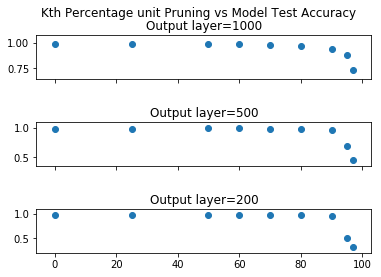

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(3, 1,sharex=True)
fig.suptitle('Kth Percentage unit Pruning vs Model Test Accuracy')
fig.subplots_adjust(hspace=1)
ax1.scatter(unit_pruning.index, unit_pruning[1000])
ax1.set_title("Output layer=1000")
ax2.scatter(unit_pruning.index, unit_pruning[500])
ax2.set_title("Output layer=500")
ax3.scatter(unit_pruning.index, unit_pruning[200])
ax3.set_title("Output layer=200")

In [16]:
# Weight Pruning
# Reload the weights of the original model
digit_classifier.model.set_weights(model_copy.get_weights())
"""Intution behind weight pruning:
Set individual weights in the weight matrix to zero. This corresponds to deleting connections as in the figure above.
Here, to achieve sparsity of k% we rank the individual weights in weight matrix W according to their magnitude (absolute value), 
and then set to zero the smallest k%.
"""

# NOTE: We are not deleting the units, just setting their weight to zero!

print("WEIGHT PRUNING")
for i in range(4,7): # We are interested in layers 4,5,6 of the model
    print("New layer")
    layer_weight_original = digit_classifier.model.layers[i].get_weights()[0] # Keep a copy of original weight
    layer_weight_temp = digit_classifier.model.layers[i].get_weights()[0] # The copy that will be modified
    layer_weight_bias = digit_classifier.model.layers[i].get_weights()[1] # Bias weights which are NOT modified
    output_size = layer_weight_temp.shape[1] #Equal to number of Cols in the weight matrix
    total_elements = layer_weight_temp.size
    for percentage in k_percent:
        smallest_k = Utility.percent_2_num(percentage, total_elements) # Find the k% percentage of total elements
        smallest_index_list = Utility.get_indices_of_k_smallest(layer_weight_temp, smallest_k) # List of k smallest index in the 2d Layer array
        for index in smallest_index_list: # For each of k% element
            layer_weight_temp[index[0]][index[1]] = 0 #Set the cell to zero
        digit_classifier.model.layers[i].set_weights([layer_weight_temp, layer_weight_bias]) # Update model's weight based on smallest K%
        acc = digit_classifier.evaluate_model() # Evaluate Test accuracy after pruning a layer.
        weight_pruning.loc[percentage][output_size] = acc #Update the corresponding pandas cell
        # Reset layer weights to original before next layer iteration, we are testing independently for each layer.
        digit_classifier.model.layers[i].set_weights([layer_weight_original, layer_weight_bias])
        print("Accuracy of layer {} at {}th percentage pruning= {}".format(output_size, percentage, acc))
print("WEIGHT PRUNING ENDS") 

WEIGHT PRUNING
New layer
10000/10000 [==============================] - 2s 163us/step
Accuracy of layer 1000 at 0th percentage pruning= 0.9828
10000/10000 [==============================] - 2s 162us/step
Accuracy of layer 1000 at 25th percentage pruning= 0.9419
10000/10000 [==============================] - 2s 163us/step
Accuracy of layer 1000 at 50th percentage pruning= 0.8732
10000/10000 [==============================] - 2s 162us/step
Accuracy of layer 1000 at 60th percentage pruning= 0.8816
10000/10000 [==============================] - 2s 161us/step
Accuracy of layer 1000 at 70th percentage pruning= 0.9042
10000/10000 [==============================] - 2s 156us/step
Accuracy of layer 1000 at 80th percentage pruning= 0.9368
10000/10000 [==============================] - 2s 159us/step
Accuracy of layer 1000 at 90th percentage pruning= 0.9641
10000/10000 [==============================] - 2s 161us/step
Accuracy of layer 1000 at 95th percentage pruning= 0.962
10000/10000 [============

In [17]:
weight_pruning #Accuracy After pruning

,1000,500,200
0,0.9828,0.9828,0.9828
25,0.9419,0.9791,0.9649
50,0.8732,0.9718,0.9040
60,0.8816,0.9729,0.9169
70,0.9042,0.9755,0.9455
80,0.9368,0.9799,0.9654
90,0.9641,0.9829,0.9767
95,0.9620,0.9834,0.9790
97,0.9375,0.9836,0.9819


Text(0.5, 1.0, 'Output layer=200')

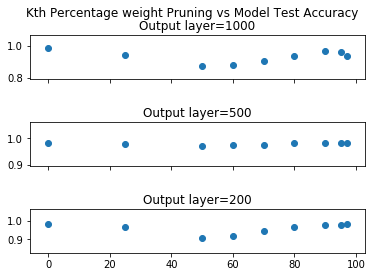

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(3, 1,sharex=True)
fig.suptitle('Kth Percentage weight Pruning vs Model Test Accuracy')
fig.subplots_adjust(hspace=1)
ax1.scatter(weight_pruning.index, weight_pruning[1000])
ax1.set_title("Output layer=1000")
ax2.scatter(weight_pruning.index, weight_pruning[500])
ax2.set_title("Output layer=500")
ax3.scatter(weight_pruning.index, weight_pruning[200])
ax3.set_title("Output layer=200")

## Observations and results
As we saw by running the weight and unit pruning, for most part out initial hypothesis holds true.
For unit pruning, as the value of k increases the accuracy decreases. For the same value of k, the least dense layer has the maximum loss of accuracy, and even a faster rate in drop of accuracy. This is because even after some columns are set to zero, there is a higher percentage of non-zero columns. Interesting, the denser the layer, lesser the affect of unit pruning. 
FOr weight pruning, the pattern was some different than expected. While we did the initial decrease in accuracy with increase in k%th, midway the accuracy started increasing again. Why is that happening? I don't know that yet.

## Todo:
1. Modify pruning set into a fucntion that takes kth and weight/unit pruning as param, and returns the kth prune model.
2. Compress and Save the sparse model.
3. Why does accuracy increase after decreasing for weight pruning?
